In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from weights import *

from numpy.linalg import norm
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.stats import linregress as linreg

import sympy as smp
smp.init_session()
smp.init_printing()
from sympy.utilities.lambdify import lambdify, implemented_function

from pytex import *

IPython console for SymPy 1.2 (Python 3.6.5-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



# 1 Order of Accuracy

In [2]:
hs1 = np.array([7.8125000e-03,
        3.9062500e-03,
        1.9531250e-03,
        9.7656250e-04,
        4.8828125e-04])

errs1 = np.array([2.0844e-02,
        1.1118e-02,
        5.3455e-03,
        2.7049e-03,
        1.3469e-03])

hs2 = np.array([7.8125000e-03,
        3.9062500e-03,
        1.9531250e-03,
        9.7656250e-04,
        4.8828125e-04,])

errs2 = np.array([1.9059e-03,
            4.3086e-04,
            1.0318e-04,
            2.6007e-05,
            6.5716e-06])

hs3 = np.array([1.00000000e+00,
        5.00000000e-01,
        2.50000000e-01,
        1.25000000e-01,
        6.25000000e-02,
        3.12500000e-02,
        1.56250000e-02,
        7.81250000e-03,
        3.90625000e-03])

errs3 = np.array([1.3829e-02,
        1.8805e-03,
        1.3742e-04,
        8.9170e-06,
        5.6252e-07,
        3.5239e-08,
        2.2037e-09,
        1.3775e-10,
        8.6098e-12])

In [3]:
ratio1 = np.log(errs1[1:]/errs1[:-1]) / np.log(hs1[1:]/hs1[:-1])
ratio2 = np.log(errs2[1:]/errs2[:-1]) / np.log(hs2[1:]/hs2[:-1])
ratio3 = np.log(errs3[1:]/errs3[:-1]) / np.log(hs3[1:]/hs3[:-1])

ratio1 = ['-'] + list(ratio1)
ratio2 = ['-'] + list(ratio2)
ratio3 = ['-'] + list(ratio3)

latex_table([hs1, errs1, ratio1],['$h$', '$e(h)$', '$p_\\text{approx}$'])
latex_table([hs2, errs2, ratio2],['$h$', '$e(h)$', '$p_\\text{approx}$'])
latex_table([hs3, errs3, ratio3],['$h$', '$e(h)$', '$p_\\text{approx}$'])

	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$h$&$e(h)$&$p_\text{approx}$\\ \hline
			0.0078125&0.020844&-\\ \hline
			0.0039062&0.011118&0.90673\\ \hline
			0.0019531&0.0053455&1.0565\\ \hline
			0.00097656&0.0027049&0.98275\\ \hline
			0.00048828&0.0013469&1.0059\\ \hline
		\end{tabular}
	\end{center}
	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$h$&$e(h)$&$p_\text{approx}$\\ \hline
			0.0078125&0.0019059&-\\ \hline
			0.0039062&0.00043086&2.1452\\ \hline
			0.0019531&0.00010318&2.0621\\ \hline
			0.00097656&2.6007e-05&1.9882\\ \hline
			0.00048828&6.5716e-06&1.9846\\ \hline
		\end{tabular}
	\end{center}
	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$h$&$e(h)$&$p_\text{approx}$\\ \hline
			1&0.013829&-\\ \hline
			0.5&0.0018805&2.8785\\ \hline
			0.25&0.00013742&3.7745\\ \hline
			0.125&8.917e-06&3.9459\\ \hline
			0.0625&5.6252e-07&3.9866\\ \hline
			0.03125&3.5239e-08&3.9967\\ \hline
			0.015625&2.2037e-09&3.9992\\ \hline
			0.0078125&1.3775e-10&3.99

In [4]:
print('p_1 = %f' % linreg(np.log(hs1[2:]), np.log(errs1[2:]))[0])
print('p_2 = %f' % linreg(np.log(hs2[2:]), np.log(errs2[2:]))[0])
print('p_3 = %f' % linreg(np.log(hs3[2:]), np.log(errs3[2:]))[0])

p_1 = 0.994341
p_2 = 1.986387
p_3 = 3.990871


In [5]:
ratio1 = ['-'] + ratio1

In [6]:
ratio1

['-',
 '-',
 0.9067348726831275,
 1.0565004830118152,
 0.9827496403905894,
 1.0059325161684725]

# 2 Finite-Volume Schemes

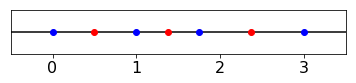

In [7]:
# plot the non-equispaced points
xs = [0, 1, 7/4, 3]
half_xs = [(x_2+x_1)/2 for x_2, x_1 in zip(xs[1:], xs[:-1])]
ys = [0]*len(xs)
half_ys = [0]*len(half_xs)

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(6,.8))
plt.xlim((-.5, 3.5))
plt.ylim((-0.05, 0.05))

plt.plot((-10,10), (0,0), 'k-')

plt.plot(xs, ys, 'bo')
plt.plot(half_xs, half_ys, 'ro')
plt.yticks([])

In [8]:
weights(11/8, half_xs, 2)

array([[ 0.        ,  1.        , -0.        ],
       [-0.60952381,  0.14285714,  0.46666667],
       [ 1.21904762, -2.28571429,  1.06666667]])

In [9]:
4/15 * np.array([5, -13, 8])

array([ 1.33333333, -3.46666667,  2.13333333])

# 3 Compact Finite Difference Formulas

In [52]:
####################################################################
#
# a and b are the end points
# N+1 is the number of points including the endpoints
# foo is either a function, or a list of function values
# dfa and dfb are the first derivatives at a and b respectively
# d2fa and d2fb are the second derivatives at a and b respectively
# 
# returns the first and second derivatives at the points
#
####################################################################
def hermite(a, b, N, foo, dfa, dfb, d2fa, d2fb):
    xs = np.linspace(a,b,N+1)
    if callable(foo):
        fs = foo(xs)
    else:
        assert len(foo)==N+1
        fs = foo
    h = (b-a)/N
    inner_N = N-1

    D1 = sp.diags( [ [1]*(inner_N-1), [4]*(inner_N),[1]*(inner_N-1) ], [-1,0,1], format='csr')
    f1 = [3/h*(-f0+f2) for f0, f2 in zip(fs[:-2], fs[2:] )]
    f1[0] -= dfa
    f1[-1] -= dfb
    fd1 = np.zeros(N+1)
    fd1[0], fd1[-1] = dfa, dfb
    fd1[1:-1] = spsolve(D1, f1)

    D2 = sp.diags( [ [1]*(inner_N-1), [10]*(inner_N),[1]*(inner_N-1) ], [-1,0,1], format='csr')
    f2 = [ 12/(h**2) * (f0 - 2*f1 + f2) for f0, f1, f2 in zip( fs[:-2], fs[1:-1], fs[2:] )]
    f2[0] -= d2fa
    f2[-1] -= d2fb
    fd2 = np.zeros(N+1)
    fd2[0], fd2[-1] = d2fa, d2fb
    fd2[1:-1] = spsolve(D2, f2)
    
    return fd1, fd2

In [53]:
a, b, N, deg = -1, 1, 100, 5

def foo(x):
    return x**deg
def dfoo(x):
    return deg * x**(deg-1)
def d2foo(x):
    if deg<2:
        return 0
    return deg*(deg-1) * x**(deg-2)


xs = np.linspace(a,b,N+1)
#fs = foo(xs)
fd1, fd2 = hermite(a, b, N, foo, dfoo(a), dfoo(b), d2foo(a), d2foo(b))

print(norm(fd1 - dfoo(xs)))
print(norm(fd2 - d2foo(xs)))

1.0666666673028808e-06
4.262545574767616e-12


In [54]:
x = smp.symbols('x')
f = x**2 * smp.exp(-x)
print(f.diff(x))
print(f.diff(x).diff(x))



-x**2*exp(-x) + 2*x*exp(-x)
x**2*exp(-x) - 4*x*exp(-x) + 2*exp(-x)


In [55]:
dfoo(1)

Text(0.5,1,'Orders of convergence for $f^\\prime$ and $f^{\\prime\\prime}$')

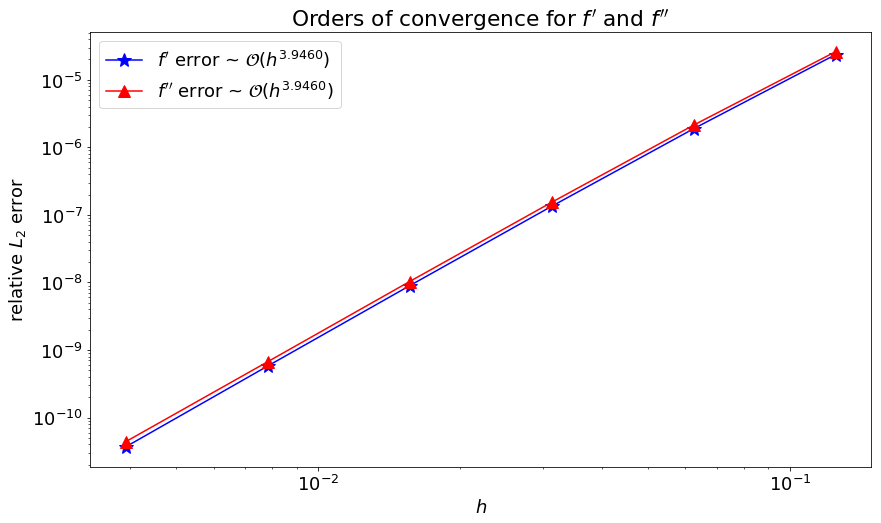

In [64]:
a, b = 0, 1
hs = [1/8 * 2**-i for i in range(6)]


def foo(x):
    return x**2 * np.exp(-x)
def dfoo(x):
    return -x**2*np.exp(-x) + 2*x*np.exp(-x)
def d2foo(x):
    return x**2*np.exp(-x) - 4*x*np.exp(-x) + 2*np.exp(-x)

Ns = [int(1/h+1) for h in hs]
d1_errors = []
d2_errors = []
for N in Ns:
    fd1, fd2 = hermite(a, b, N, foo, dfoo(a), dfoo(b), d2foo(a), d2foo(b))
    xs = np.linspace(a,b,N+1)
    d1_errors += [norm(fd1 - dfoo(xs))/norm(dfoo(xs))]
    d2_errors += [norm(fd2 - d2foo(xs))/norm(dfoo(xs))]
    
order1 = linreg(np.log(hs[2:]), np.log(d1_errors[2:]))[0]
#order1 = np.log(d1_errors[-1]/d1_errors[-2]) / np.log(hs[-1]/hs[-2])
order2 = linreg(np.log(hs[2:]), np.log(d2_errors[2:]))[0]
#order2 = np.log(d2_errors[-1]/d2_errors[-2]) / np.log(hs[-1]/hs[-2])

legend = ['$f^\prime$ error ~ $\mathcal{O}(h^{%.4f})$' % order1]
legend += ['$f^{\prime\prime}$ error ~ $\mathcal{O}(h^{%.4f})$' % order1]

matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14,8))

plt.loglog(hs, d1_errors, 'b-*', markersize=15)
plt.loglog(hs, d2_errors, 'r-^', markersize=12)
plt.legend(legend)
plt.xlabel('$h$')
plt.ylabel('relative $L_2$ error')
plt.title('Orders of convergence for $f^\prime$ and $f^{\prime\prime}$')

In [57]:
orders1 = [np.log(err1/err0)/np.log(.5) for err0, err1 in zip(d1_errors[:-1], d1_errors[1:])]
orders1 = ['-'] + orders1
orders2 = [np.log(err1/err0)/np.log(.5) for err0, err1 in zip(d2_errors[:-1], d2_errors[1:])]
orders2 = ['-'] + orders2
latex_table([hs, d1_errors, orders1, d2_errors, orders2], 
            headers=['$h$', '$f^\prime$ erorr', '$f^\prime$ erorr ratio', '$f^{\prime\prime}$ erorr', '$f^{\prime\prime}$ erorr ratio'])

	\begin{center}
		\begin{tabular}{|c|c|c|c|c|}
			\hline
			$h$&$f^\prime$ erorr&$f^\prime$ erorr ratio&$f^{\prime\prime}$ erorr&$f^{\prime\prime}$ erorr ratio\\ \hline
			0.125&2.3696e-05&-&2.6188e-05&-\\ \hline
			0.0625&1.8918e-06&3.6468&2.1392e-06&3.6138\\ \hline
			0.03125&1.3428e-07&3.8165&1.5384e-07&3.7976\\ \hline
			0.015625&8.9542e-09&3.9065&1.0331e-08&3.8963\\ \hline
			0.0078125&5.7825e-10&3.9528&6.6964e-10&3.9475\\ \hline
			0.0039062&3.674e-11&3.9763&4.3799e-11&3.9344\\ \hline
		\end{tabular}
	\end{center}


In [7]:
n = 6
x0 = 0

x, h = smp.symbols('x h')
f = smp.Function('f')

right = f(x+h).series(x+h, x0=x0, n=n)
right -= f(x-h).series(x-h, x0=x0, n=n)
right *= 3/h
right = right.subs(x,x0).simplify()
display(right)

left = f(x+h).series(x+h, x0=x0, n=n).diff(x) + f(x-h).series(x-h, x0=x0, n=n).diff(x)
left += 4*f(x).diff(x).subs(x,x0)
left = left.subs(x,x0).simplify()
display(left)

err = (left - right).subs(x,0).simplify()
display(err)

                                           ⎛  5      ⎞│           
                                         4 ⎜ d       ⎟│           
                                        h ⋅⎜───(f(x))⎟│           
                      ⎛  3      ⎞│         ⎜  5      ⎟│           
  ⎛d       ⎞│       2 ⎜ d       ⎟│         ⎝dx       ⎠│x=0    ⎛ 5⎞
6⋅⎜──(f(x))⎟│    + h ⋅⎜───(f(x))⎟│    + ────────────────── + O⎝h ⎠
  ⎝dx      ⎠│x=0      ⎜  3      ⎟│              20                
                      ⎝dx       ⎠│x=0                             

                                           ⎛  5      ⎞│           
                                         4 ⎜ d       ⎟│           
                                        h ⋅⎜───(f(x))⎟│           
                      ⎛  3      ⎞│         ⎜  5      ⎟│           
  ⎛d       ⎞│       2 ⎜ d       ⎟│         ⎝dx       ⎠│x=0    ⎛ 5⎞
6⋅⎜──(f(x))⎟│    + h ⋅⎜───(f(x))⎟│    + ────────────────── + O⎝h ⎠
  ⎝dx      ⎠│x=0      ⎜  3      ⎟│              12                
                      ⎝dx       ⎠│x=0                             

   ⎛  5      ⎞│           
 4 ⎜ d       ⎟│           
h ⋅⎜───(f(x))⎟│           
   ⎜  5      ⎟│           
   ⎝dx       ⎠│x=0    ⎛ 5⎞
────────────────── + O⎝h ⎠
        30                

In [8]:
print(smp.latex(right))
print(smp.latex(left))
print(smp.latex(err))

6 \left. \frac{d}{d x} f{\left (x \right )} \right|_{\substack{ x=0 }} + h^{2} \left. \frac{d^{3}}{d x^{3}} f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{h^{4} \left. \frac{d^{5}}{d x^{5}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{20} + O\left(h^{5}\right)
6 \left. \frac{d}{d x} f{\left (x \right )} \right|_{\substack{ x=0 }} + h^{2} \left. \frac{d^{3}}{d x^{3}} f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{h^{4} \left. \frac{d^{5}}{d x^{5}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{12} + O\left(h^{5}\right)
\frac{h^{4} \left. \frac{d^{5}}{d x^{5}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{30} + O\left(h^{5}\right)


In [284]:
n = 7
x0 = 0

x, h = smp.symbols('x h')
f = smp.Function('f')

right = f(x+h).series(x+h, x0=x0, n=n)
right += f(x-h).series(x-h, x0=x0, n=n)
right += -2*f(x)
right *= 12/(h**2)
right = right.subs(x,x0).simplify()
display(right)

left = f(x+h).series(x+h, x0=x0, n=n).diff(x,2) 
left += f(x-h).series(x-h, x0=x0, n=n).diff(x,2)
left += 10*f(x).diff(x,2)
left = left.subs(x,x0).simplify()
display(left)

err = (left - right).subs(x,0).simplify()
display(err)

                                             ⎛  6      ⎞│           
                                           4 ⎜ d       ⎟│           
                                          h ⋅⎜───(f(x))⎟│           
   ⎛  2      ⎞│         ⎛  4      ⎞│         ⎜  6      ⎟│           
   ⎜ d       ⎟│       2 ⎜ d       ⎟│         ⎝dx       ⎠│x=0    ⎛ 5⎞
12⋅⎜───(f(x))⎟│    + h ⋅⎜───(f(x))⎟│    + ────────────────── + O⎝h ⎠
   ⎜  2      ⎟│         ⎜  4      ⎟│              30                
   ⎝dx       ⎠│x=0      ⎝dx       ⎠│x=0                             

                                             ⎛  6      ⎞│           
                                           4 ⎜ d       ⎟│           
                                          h ⋅⎜───(f(x))⎟│           
   ⎛  2      ⎞│         ⎛  4      ⎞│         ⎜  6      ⎟│           
   ⎜ d       ⎟│       2 ⎜ d       ⎟│         ⎝dx       ⎠│x=0    ⎛ 5⎞
12⋅⎜───(f(x))⎟│    + h ⋅⎜───(f(x))⎟│    + ────────────────── + O⎝h ⎠
   ⎜  2      ⎟│         ⎜  4      ⎟│              12                
   ⎝dx       ⎠│x=0      ⎝dx       ⎠│x=0                             

   ⎛  6      ⎞│           
 4 ⎜ d       ⎟│           
h ⋅⎜───(f(x))⎟│           
   ⎜  6      ⎟│           
   ⎝dx       ⎠│x=0    ⎛ 5⎞
────────────────── + O⎝h ⎠
        20                

In [285]:
print(smp.latex(right))
print(smp.latex(left))
print(smp.latex(err))

12 \left. \frac{d^{2}}{d x^{2}} f{\left (x \right )} \right|_{\substack{ x=0 }} + h^{2} \left. \frac{d^{4}}{d x^{4}} f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{h^{4} \left. \frac{d^{6}}{d x^{6}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{30} + O\left(h^{5}\right)
12 \left. \frac{d^{2}}{d x^{2}} f{\left (x \right )} \right|_{\substack{ x=0 }} + h^{2} \left. \frac{d^{4}}{d x^{4}} f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{h^{4} \left. \frac{d^{6}}{d x^{6}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{12} + O\left(h^{5}\right)
\frac{h^{4} \left. \frac{d^{6}}{d x^{6}} f{\left (x \right )} \right|_{\substack{ x=0 }}}{20} + O\left(h^{5}\right)


# 4 Increasing the FD Stencil Width

In [13]:
x = smp.symbols('x')
expr = smp.exp(-smp.cos(2*(x-.2)))
foo = smp.lambdify(x, expr)
dfoo = smp.lambdify(x, expr.diff(x))

points = ['Equispaced', 'Chebyshev', 'Legendre']
errs_0 = []
errs_1 = []
all_weights = []

## Equispaced

	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$x$&weights for $z=0.00$&weights for $z=-0.79$\\ \hline
			-1&-0.00029138&0.097975\\ \hline
			-0.85714&0.0047591&-6.2847\\ \hline
			-0.71429&-0.037121&1.4593\\ \hline
			-0.57143&0.18561&16.859\\ \hline
			-0.42857&-0.68056&-34.022\\ \hline
			-0.28571&2.0417&52.402\\ \hline
			-0.14286&-6.125&-63.599\\ \hline
			0&-1.1879e-14&60.934\\ \hline
			0.14286&6.125&-45.866\\ \hline
			0.28571&-2.0417&26.818\\ \hline
			0.42857&0.68056&-11.939\\ \hline
			0.57143&-0.18561&3.912\\ \hline
			0.71429&0.037121&-0.88992\\ \hline
			0.85714&-0.0047591&0.12559\\ \hline
			1&0.00029138&-0.0082855\\ \hline
		\end{tabular}
	\end{center}


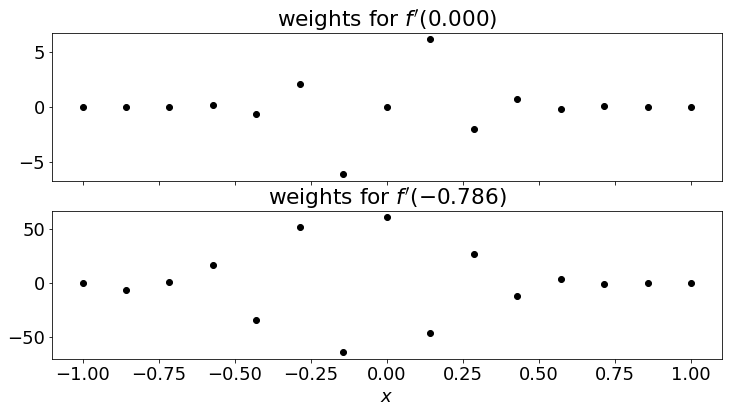

In [14]:
xs = np.linspace(-1,1, 15)

zs = [0,-1+3/14]
ws = []

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2, sharex=True, figsize=(12,6))
for i, (ax, z) in enumerate(zip(axs, zs)):
    w = weights(z, xs, 1)[1]
    all_weights += [w]
    ws.append(w)
    ax.set_title('weights for $f^\prime(%.3f)$'%z)
    ax.plot(xs, w, 'ko')
    
errs_0.append(norm(np.dot(foo(xs), ws[0]) - dfoo(zs[0]))/norm(dfoo(zs[0])))
errs_1.append(norm(np.dot(foo(xs), ws[1]) - dfoo(zs[1]))/norm(dfoo(zs[1])))
    
plt.xlabel('$x$')
latex_table([xs, ws[0], ws[1]], ['$x$', 'weights for $z=%.2f$'%zs[0], 'weights for $z=%.2f$'%zs[1]] )

## Chebyshev

	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$x$&weights for $z=0.00$&weights for $z=-0.79$\\ \hline
			-1&-0.5&-2.348\\ \hline
			-0.97493&1.0257&5.3308\\ \hline
			-0.90097&-1.1099&-8.8652\\ \hline
			-0.78183&1.279&1.6842\\ \hline
			-0.62349&-1.6039&5.945\\ \hline
			-0.43388&2.3048&-2.7777\\ \hline
			-0.22252&-4.494&1.7425\\ \hline
			-6.1232e-17&-1.2212e-15&-1.2515\\ \hline
			0.22252&4.494&0.97637\\ \hline
			0.43388&-2.3048&-0.8077\\ \hline
			0.62349&1.6039&0.69933\\ \hline
			0.78183&-1.279&-0.62887\\ \hline
			0.90097&1.1099&0.58455\\ \hline
			0.97493&-1.0257&-0.56005\\ \hline
			1&0.5&0.2761\\ \hline
		\end{tabular}
	\end{center}


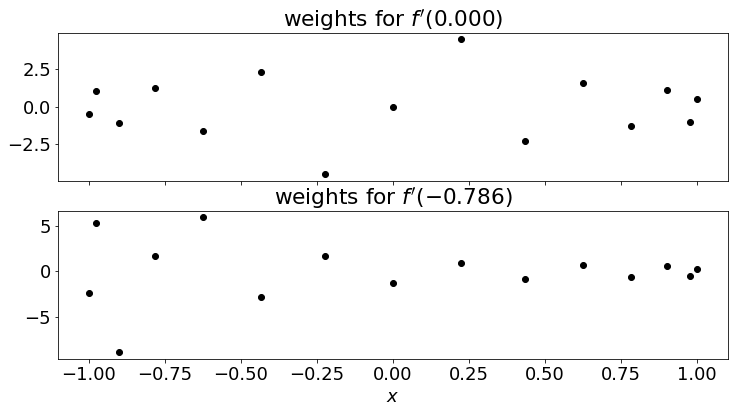

In [15]:
xs = -np.cos(np.linspace(0,np.pi, 15))

zs = [0,-1+3/14]
ws = []

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2, sharex=True, figsize=(12,6))
for i, (ax, z) in enumerate(zip(axs, zs)):
    w = weights(z, xs, 1)[1]
    all_weights += [w]
    ws.append(w)
    ax.set_title('weights for $f^\prime(%.3f)$'%z)
    ax.plot(xs, w, 'ko')

errs_0.append(norm(np.dot(foo(xs), ws[0]) - dfoo(zs[0]))/norm(dfoo(zs[0])))
errs_1.append(norm(np.dot(foo(xs), ws[1]) - dfoo(zs[1]))/norm(dfoo(zs[1])))
    
plt.xlabel('$x$')
latex_table([xs, ws[0], ws[1]], ['$x$', 'weights for $z=%.2f$'%zs[0], 'weights for $z=%.2f$'%zs[1]] )

## Legendre

	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			$x$&weights for $z=0.00$&weights for $z=-0.79$\\ \hline
			-0.98799&-0.06093&-0.21617\\ \hline
			-0.93727&0.2192&1.1672\\ \hline
			-0.84821&-0.45417&-10.026\\ \hline
			-0.72442&0.78988&9.3704\\ \hline
			-0.57097&-1.3026&-0.19053\\ \hline
			-0.39415&2.2352&-0.26132\\ \hline
			-0.20119&-4.8186&0.30643\\ \hline
			0&4.4949e-16&-0.28052\\ \hline
			0.20119&4.8186&0.23726\\ \hline
			0.39415&-2.2352&-0.19042\\ \hline
			0.57097&1.3026&0.14473\\ \hline
			0.72442&-0.78988&-0.10234\\ \hline
			0.84821&0.45417&0.064645\\ \hline
			0.93727&-0.2192&-0.033001\\ \hline
			0.98799&0.06093&0.0094389\\ \hline
		\end{tabular}
	\end{center}


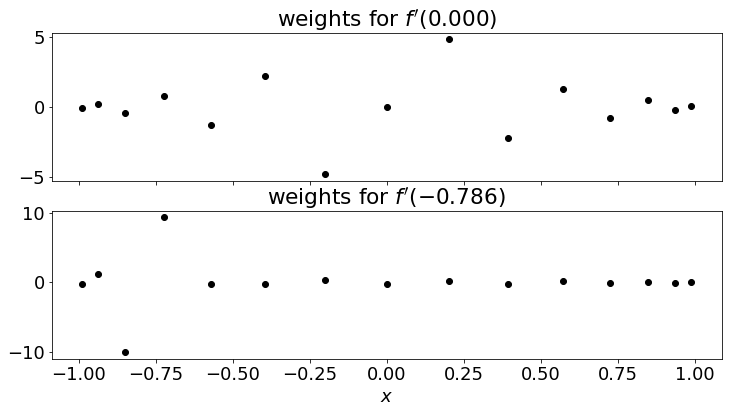

In [16]:
xs = np.sort([-0.987992518020485,-0.394151347077563,0.570972172608539,-0.937273392400706,-0.201194093997435,
      0.724417731360170,-0.848206583410427,0,0.848206583410427,-0.724417731360170,0.201194093997435,
      0.937273392400706,-0.570972172608539,0.394151347077563,0.987992518020485])

zs = [0,-1+3/14]
ws = []

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2, sharex=True, figsize=(12,6))
for i, (ax, z) in enumerate(zip(axs, zs)):
    w = weights(z, xs, 1)[1]
    all_weights += [w]
    ws.append(w)
    ax.set_title('weights for $f^\prime(%.3f)$'%z)
    ax.plot(xs, w, 'ko')
    
errs_0.append(norm(np.dot(foo(xs), ws[0]) - dfoo(zs[0]))/norm(dfoo(zs[0])))
errs_1.append(norm(np.dot(foo(xs), ws[1]) - dfoo(zs[1]))/norm(dfoo(zs[1])))

plt.xlabel('$x$')
latex_table([xs, ws[0], ws[1]], ['$x$', 'weights for $z=%.2f$'%zs[0], 'weights for $z=%.2f$'%zs[1]] )

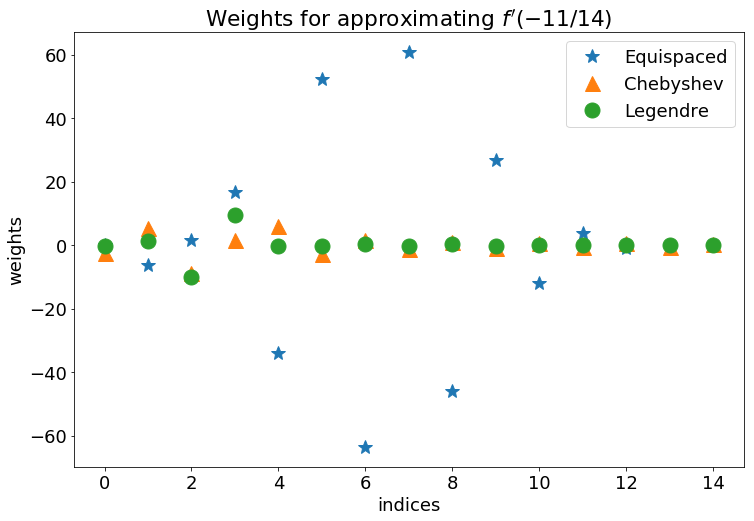

In [51]:
matplotlib.rcParams.update({'font.size': 18})
ms = 15
second_pnt = True

fig, axs = plt.subplots(1, sharex=True, figsize=(12,8))
xid = range(len(xs))

axs.plot(xid, all_weights[0+second_pnt], '*', markersize=ms)
axs.plot(xid, all_weights[2+second_pnt], '^', markersize=ms)
axs.plot(xid, all_weights[4+second_pnt], 'o', markersize=ms)
axs.legend(points)
plt.xlabel('indices')
plt.ylabel('weights')
if second_pnt:
    plt.title('Weights for approximating $f^\prime(-11/14)$')
else:
    plt.title('Weights for approximating $f^\prime(0)$')

# 4(b)

In [6]:
latex_table([points, errs_0, errs_1], ['Points', 'Error in $f^\prime(0)$', 'Error in $f^\prime(-\\tfrac{11}{14})$'])

	\begin{center}
		\begin{tabular}{|c|c|c|}
			\hline
			Points&Error in $f^\prime(0)$&Error in $f^\prime(-\tfrac{11}{14})$\\ \hline
			Equispaced&5.2314e-07&1.4426e-06\\ \hline
			Chebyshev&1.0728e-05&4.5105e-07\\ \hline
			Legendre&5.8603e-06&9.2153e-08\\ \hline
		\end{tabular}
	\end{center}


# 5 Tigonometric Interpolation

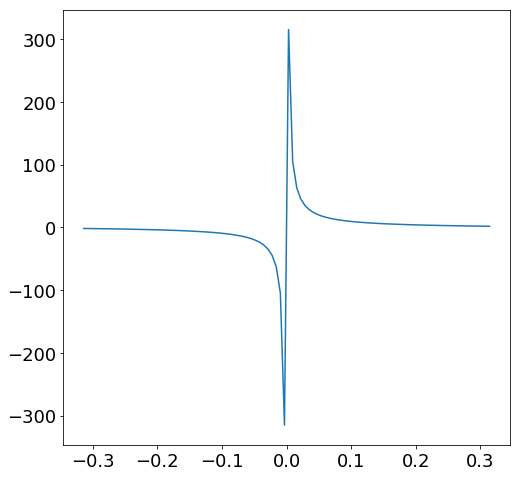

In [91]:
N = 12
step = 10**1

fig, axs = plt.subplots(1, sharex=True, figsize=(8,8))
ts = np.linspace(-np.pi/step, np.pi/step, 100)
plt.plot(ts, np.cos(ts)**N * np.sin(ts)/(np.sin(ts)**2))